## Visualization of fingerprints

This notebook generates additional visualization of task fingerprints and task distances.

In [94]:
from pathlib import Path
import mml.interactive
mml.interactive.init(Path('~/.config/mml.env').expanduser())
from mml_tf.representations import FullFeatureRepresentations, BinnedFeatureRepresentations
from mml_tf.distances import LoadCachedDistances, TaskDistances
import plotly.express as px
import pandas as pd
import numpy as np
from mml_similarity.visualization.plot_2D import DistancePlotConfig, create_color_mapping, plot_tsne
from typing import Tuple
from mml_tf.tasks import all_tasks, train_tasks, test_tasks

MML API already initialized.


In [12]:

ff = FullFeatureRepresentations()
ff.load_representations()

In [6]:
bf = BinnedFeatureRepresentations(full_features=ff, n_bins=10)
bf.load_representations()

In [21]:
rng = np.random.default_rng(seed=123)
task = rng.choice(all_tasks)
print(task)

lapgyn4_surgical_actions


In [22]:
# m=512 features for the first n=100 samples 
px.imshow(ff.mapping[task][:100,:])

In [23]:
# binned features fingerprint for b=10 
px.imshow(bf.mapping[task], width=400, aspect='auto').show()

In [24]:
def get_bins(tasks: Tuple[str], f_dim=0, rep=bf):
    rows = []
    n_bins = rep.n_bins
    for task in tasks:
        for bin in range(n_bins):
            rows.append({'task': task, 'bin': bin, 'frac': rep.mapping[task][f_dim, bin].item()})
    return px.bar(pd.DataFrame(rows), x='bin', y='frac', color='task', barmode='group')

In [25]:
get_bins(tasks=tuple(rng.choice(all_tasks) for _ in range(3)), f_dim=1)

The standardized task distances can be interpreted as follows: 
- row: source task
- column: target task, index 0-70 are the "full" targets, 71-126 are the "shrunk" targets (some tasks are so small they may not be shrunk)

The "diagonals" are the "self-distance" (which is set NaN). The blocks occur for grouped tasks (e.g. CheXpert is the largest, index 33 - 46)

In [40]:
kld = LoadCachedDistances('KLD-PP:NN', zscore_axis=0)
px.imshow(kld.df.values)

In [39]:
vdna = LoadCachedDistances('VDNA-PP:NN-1000-BINS', zscore_axis=0)
px.imshow(vdna.df.values)

In [41]:
bkld = LoadCachedDistances('KLD-PP:NS-W:TS-100-BINS', zscore_axis=0)
px.imshow(bkld.df.values)

In [92]:
def plot_task_space(dist: TaskDistances, criteria: str = 'domain'):
    # drop shrunk versions to have a square matrix
    square_df = dist.df[list(all_tasks)]
    if (square_df < 0).any().any():
        smallest = square_df.min().min()
        square_df += 1.1 * (-smallest)
    for t in all_tasks:
        square_df.at[t,t] = 0.
    cfg = DistancePlotConfig(legend_size=10)
    if criteria == 'split':
        color_map, legend_map = create_color_mapping(task_list=mml.interactive.get_task_structs(all_tasks), task_clusters={'develop': train_tasks, 'validation': test_tasks})
    else:
        color_map, legend_map = create_color_mapping(task_list=mml.interactive.get_task_structs(all_tasks), criteria=criteria)
    return plot_tsne(distances=square_df, plot_cfg=cfg, color_map=color_map, legend_map=legend_map)

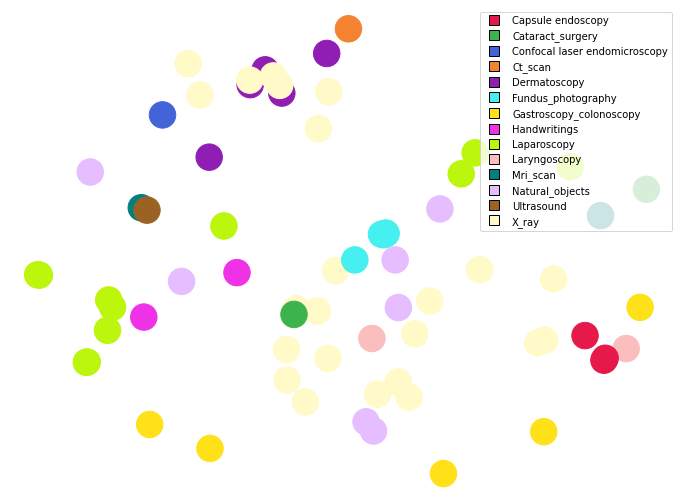

In [84]:
fig = plot_task_space(kld)

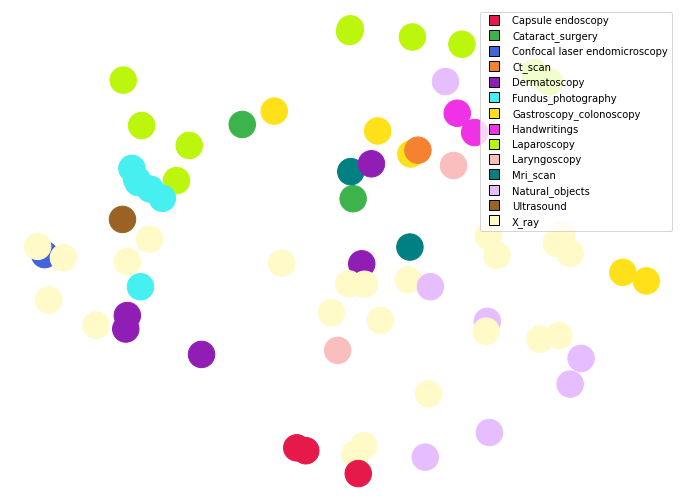

In [85]:
fig = plot_task_space(vdna)

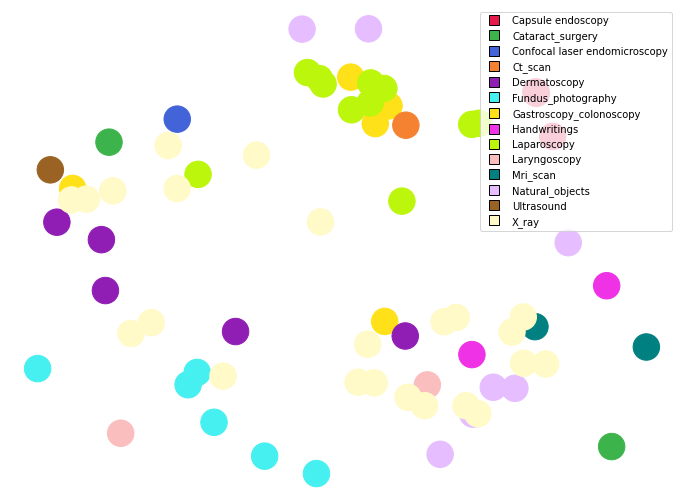

In [86]:
fig = plot_task_space(bkld)

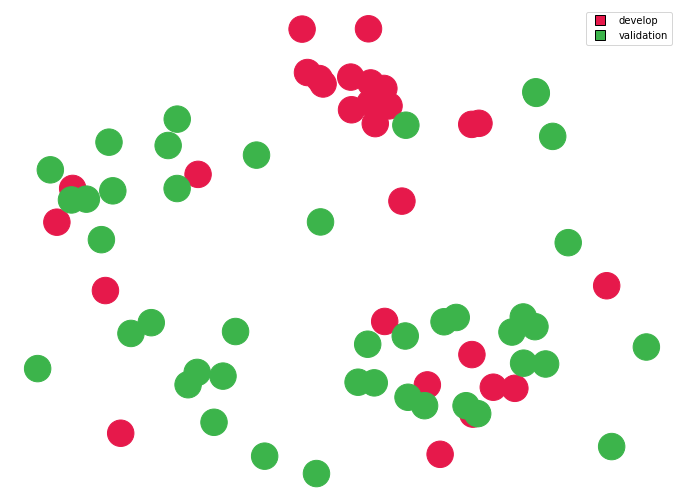

In [95]:
fig = plot_task_space(bkld, criteria='split')